Import neccessary libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import warnings

Suppress warnings to keep the output clean during training and scaling

Data Loading and Initial Inspection

In [45]:
# Load the dataset from the provided CSV file into a pandas DataFrame
try:
    df = pd.read_csv("data.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'data.csv' was not found. Please check if it is present in the current directory")

Data loaded successfully!


In [46]:
print("----- Initial Data Snapshot")
print(df.head())

----- Initial Data Snapshot
   Age Education_Level  ... Primary_Mode_of_Transportation  Income
0   56        Master's  ...                 Public transit   72510
1   69     High School  ...                         Biking   75462
2   46      Bachelor's  ...                            Car   71748
3   32     High School  ...                            Car   74520
4   60      Bachelor's  ...                        Walking  640210

[5 rows x 14 columns]


In [47]:
print("----- Data Information -----")
print(df.info())

----- Data Information -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             10000 non-null  int64 
 1   Education_Level                 10000 non-null  object
 2   Occupation                      10000 non-null  object
 3   Number_of_Dependents            10000 non-null  int64 
 4   Location                        10000 non-null  object
 5   Work_Experience                 10000 non-null  int64 
 6   Marital_Status                  10000 non-null  object
 7   Employment_Status               10000 non-null  object
 8   Household_Size                  10000 non-null  int64 
 9   Homeownership_Status            10000 non-null  object
 10  Type_of_Housing                 10000 non-null  object
 11  Gender                          10000 non-null  object
 12  Primary_Mode_of_Tr

TARGET COLUMN

In [48]:
TARGET_COLUMN = "Income"

Exploratory Data Analysis (EDA) and Visualization (Before Training)

In [49]:
# Set up the visualization style for better aesthetics
sns.set_style("whitegrid")

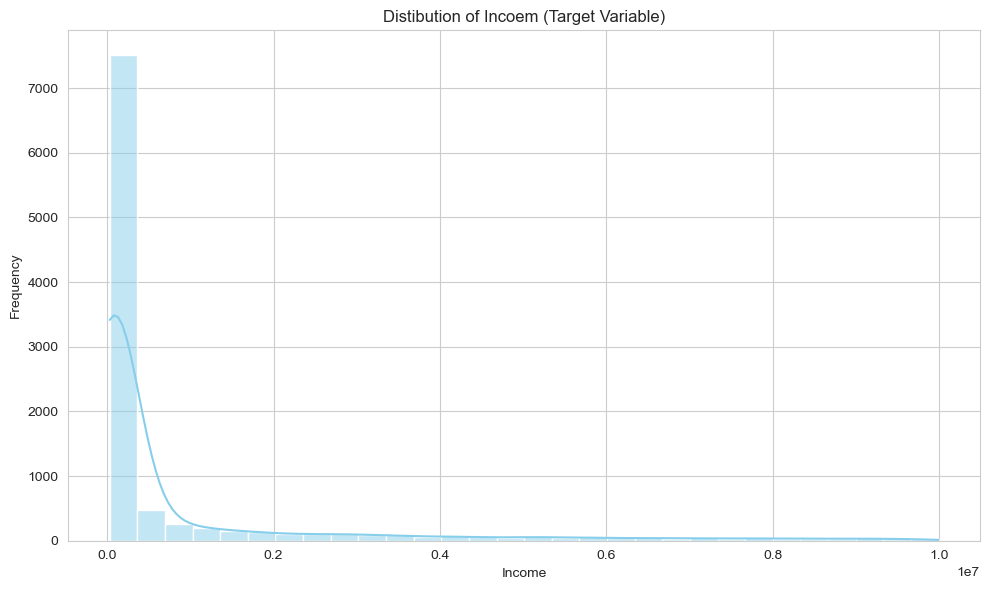

In [50]:
plt.figure(figsize=(10,6))
# Use a dstribution plot (histogram with a kernel density estimate) to show the shape of the Income data.
sns.histplot(df[TARGET_COLUMN],bins=30,kde=True,color="skyblue")
# Set the title for the plot
plt.title("Distibution of Incoem (Target Variable)")
# Add a label for the x-axis 
plt.xlabel("Income")
# Add a label for the y-axis (Frequency/Density)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

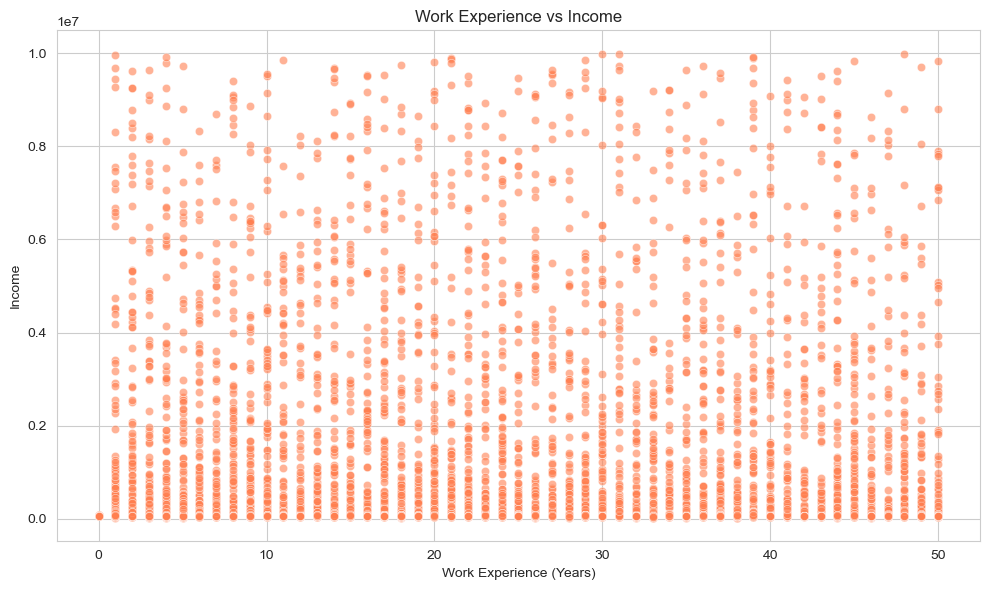

In [51]:
plt.figure(figsize=(10,6))
# Use a scatter plot to visualize the correlation between work experience and income
sns.scatterplot(x="Work_Experience",y=TARGET_COLUMN,data=df,alpha=0.6,color="coral")
#  Set the title for the scatter plot
plt.title("Work Experience vs Income")
# Add  a label for the x-axis
plt.xlabel("Work Experience (Years)")
# Add a label for the y-axis
plt.ylabel("Income")
plt.tight_layout()
plt.show()

Data Preprocessing 

In [52]:
# Check for missing values
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
Age                               0
Education_Level                   0
Occupation                        0
Number_of_Dependents              0
Location                          0
Work_Experience                   0
Marital_Status                    0
Employment_Status                 0
Household_Size                    0
Homeownership_Status              0
Type_of_Housing                   0
Gender                            0
Primary_Mode_of_Transportation    0
Income                            0
dtype: int64


In [53]:
# Check for dupliacted rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


Feature Engineering

In [54]:
# Identify numerical columns that will be scaled
numerical_cols = ["Age","Number_of_Dependents","Work_Experience","Household_Size"]
# Identify all categorical columns in the dataset
categorical_cols = df.select_dtypes(include=["object"]).columns.to_list()

In [55]:
# Apply One-Hot Encoding to all categorical features
# drop_first=True is used to avoild multicollinearity (the Dummy Variable Trap)
df_encoded = pd.get_dummies(df,columns=categorical_cols,drop_first=True)

In [56]:
# Separate feature matrix (X) and target variable (y)
X = df_encoded.drop(columns=[TARGET_COLUMN])
y = df_encoded[TARGET_COLUMN]

Data Splitting

In [57]:
# Split the data into training (80%) and testing (20%)
# random_state ensures reproducibility
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Data Scaling

In [58]:
# Initialize the StandardScaler for scaling the numerical features
# StandardScaler standardizes features by removing the mean and scalin to unit variance
scaler = StandardScaler()

# Fit the scaler only on the training data to prevent data leakae from the test set
scaler.fit(X_train[numerical_cols])

# Apply the transformation to both the training and testing sets
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [59]:
# Confirm the shape of the final training data
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print("-"*50)

Training features shape: (8000, 24)
Testing features shape: (2000, 24)
--------------------------------------------------


Model Comparison and Evaluation

In [60]:
# Define a function to train a model, make predictions and evaluate its performance
def evaluate_model(model,X_train,y_train,X_test,y_test):
    # Train the model using the training data
    model.fit(X_train,y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    # return the calculated metrics
    return mae,rmse,r2,model

In [61]:
# Dictionary of regression models to be compared
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Regression" : Ridge(random_state=42),
    "Lasso Regression" : Lasso(random_state=42,max_iter=10000),
    "ElasticNet Regression" : ElasticNet(random_state=42,max_iter=10000),
    "Decision Tree Regressor" : DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor" : RandomForestRegressor(random_state=42,n_jobs=1),
    "Support Vector Regression" : SVR()
}

In [62]:
# Create an empty list to store the results of all models
results = []

# Initialize a variable to track the best R-sqauared score found so far
best_r2 = -np.inf

# Initialize a variable to store the name of the best model
best_model_name = ""

In [63]:
# Iterate through each model in the dictionary
print("----- Regression Model Comparison -----")
for name,model in models.items():
    # Evaluate the current model
    mae,rmse,r2,trained_model = evaluate_model(model,X_train,y_train,X_test,y_test)
    # Append the results to the list
    results.append({
        "Model" : name,
        "R2 Score" : r2,
        "MAE" : mae,
        "RMSE" : rmse
    })

    # Check if the current model is the best so far (based on R2 Score)
    if r2 > best_r2:
        best_r2 = r2
        best_model_name = name
        #  Store the best trained model object for later tuning
        best_model = trained_model



# Convert the results list into a DataFrame for easy viewing and sorting
results_df = pd.DataFrame(results).sort_values(by="R2 Score",ascending=False)

# Display the comparison table
print(results_df.to_markdown(index=False))
print("-"*50)
print(f"The best performing base model is : {best_model_name} (R2={best_r2:.4f})")
print("-"*50)

----- Regression Model Comparison -----
| Model                     |    R2 Score |              MAE |        RMSE |
|:--------------------------|------------:|-----------------:|------------:|
| Ridge Regression          |  0.00586846 |      1.10218e+06 | 1.77097e+06 |
| Lasso Regression          |  0.0058624  |      1.10217e+06 | 1.77098e+06 |
| Linear Regression         |  0.00586219 |      1.10217e+06 | 1.77098e+06 |
| ElasticNet Regression     |  0.00443911 |      1.11272e+06 | 1.77225e+06 |
| Random Forest Regressor   | -0.0085391  |      1.1818e+06  | 1.78376e+06 |
| Support Vector Regression | -0.177441   | 754280           | 1.92735e+06 |
| Decision Tree Regressor   | -1.19465    |      1.34016e+06 | 2.63131e+06 |
--------------------------------------------------
The best performing base model is : Ridge Regression (R2=0.0059)
--------------------------------------------------


Hyperparameter Tuning (Grid Search) on the Best Model

In [64]:
# We choose Random Forest as it typically performs well and benefits greatly from tuning
if best_model_name == "Random Forest Regressor":
    # Define the parameter grid to search over
    param_grid = {
        "n_estimators" : [50,100,150],
        "max_depth" : [None,10,20],
        "min_samples_split" : [2,5],
        "min_samples_leaf" : [1,2]
    }
else:
    # If the best model wasn't Random Forest, We'll tune Random Forest anyway for demmonstration
    print("For demonstration, performing Hyperparameter Tuning on Random Forest Regressor.")
    best_model = RandomForestRegressor(random_state=42,n_jobs=1)
    param_grid = {
        "n_estimators" : [50,100],
        "max_depth" : [10,20]
    }

For demonstration, performing Hyperparameter Tuning on Random Forest Regressor.


In [65]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    verbose=1,
    n_jobs=1
)

In [66]:
# Fit the GridSearch to the training data to find the optimal hyperparameters
print("Starting GridSearchCV for the Hyperparameter Tuning.......")
grid_search.fit(X_train,y_train)

# Retrieve the best model found by the grid search
best_tuned_model = grid_search.best_estimator_

# Print the best parameters found
print("----- Hyperparameter Tuning Results -----")
print(f"Best Parameters found: {grid_search.best_params_}")

# Evaluate the final best-tuned model on the test set
y_pred_tuned = best_tuned_model.predict(X_test)

# Calculate final metrics for the tuned model
mae_tuned = mean_absolute_error(y_test,y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test,y_pred_tuned))
r2_tuned = r2_score(y_test,y_pred_tuned)


print(f"Tuned Model ({best_model_name}) Final Metrics:")
print(f"R2 Score: {r2_tuned:.4f}")
print(f"MAE: {mae_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print("-"*50)

Starting GridSearchCV for the Hyperparameter Tuning.......
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----- Hyperparameter Tuning Results -----
Best Parameters found: {'max_depth': 10, 'n_estimators': 100}
Tuned Model (Ridge Regression) Final Metrics:
R2 Score: 0.0203
MAE: 1110077.67
RMSE: 1758066.07
--------------------------------------------------


Visualization After Training

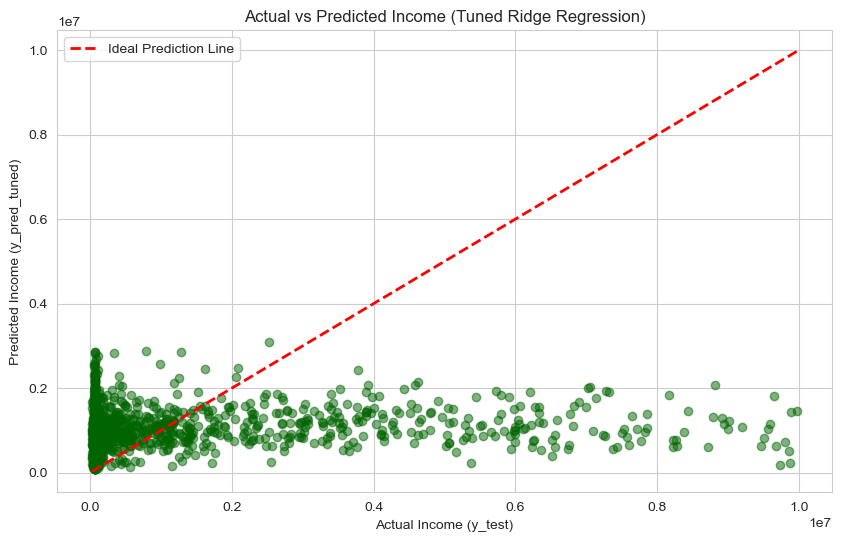

In [70]:
# Create a figure for the final visualization of the tuned model's predictions
plt.figure(figsize=(10,6))

# Subplot 1: Actual vs Predicted Values Scatter plot
# The predictions from the tuned model are used 
plt.scatter(y_test,y_pred_tuned,alpha=0.5,color="darkgreen")

# Plot the ideal line (where Actual = Predicted ) for comparison
# Find the minimum and maximum income values for the line
min_val = min(y_test.min(),y_pred_tuned.min())
max_val = max(y_test.max(),y_pred_tuned.max())

# Plot the 45-degree line
plt.plot([min_val,max_val],[min_val,max_val],color="red",linestyle="--",linewidth=2,label="Ideal Prediction Line")


# Set the title and labels
plt.title(f"Actual vs Predicted Income (Tuned {best_model_name})")
plt.xlabel("Actual Income (y_test)")
plt.ylabel("Predicted Income (y_pred_tuned)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_22552\2446829691.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


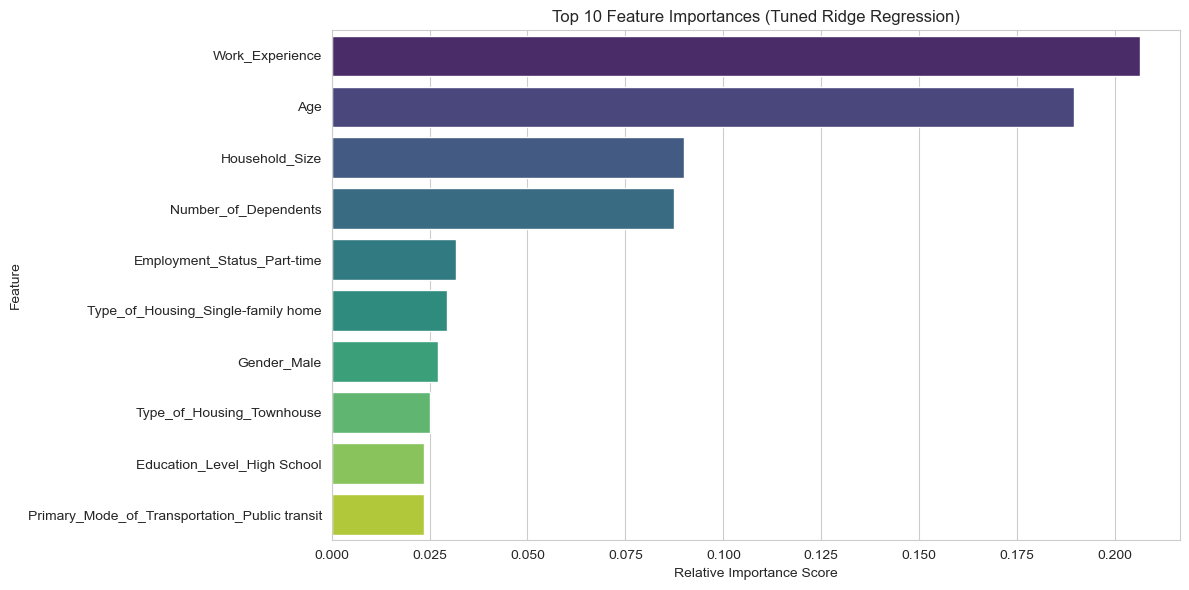

Displayed Feature Importance Visualization.


In [71]:
# Final check of the top model's feature importance (for Random Forest).
if hasattr(best_tuned_model, 'feature_importances_'):
    # Get feature importance from the tuned Random Forest model.
    importances = best_tuned_model.feature_importances_
    # Match importances with feature names.
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    # Sort by importance in descending order.
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

    # Plot the top 10 most important features.
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top 10 Feature Importances (Tuned {best_model_name})')
    plt.xlabel('Relative Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print("Displayed Feature Importance Visualization.")